In [142]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import shutil
import random

In [143]:

# Define the data directory
data_dir = "../data/external/chest_xray_1c/"

# Define counters for images with 3 channels
num_images_with_3_channels_train = 0
num_images_with_3_channels_test = 0
num_images_with_3_channels_val = 0

# Define datasets
datasets_xray = ['train', 'test', 'val']

# Iterate through each dataset
for dataset in datasets_xray:
    print(f"Dataset: {dataset}")
    dataset_dir = os.path.join(data_dir, dataset)
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            # Load the image
            image_path = os.path.join(root, file)
            image = Image.open(image_path)
            # Check if the image has 3 channels
            if len(image.getbands()) == 3:
                if dataset == 'train':
                    num_images_with_3_channels_train += 1
                elif dataset == 'test':
                    num_images_with_3_channels_test += 1
                elif dataset == 'val':
                    num_images_with_3_channels_val += 1

# Print the results
print("Number of images with 3 channels in train set:", num_images_with_3_channels_train)
print("Number of images with 3 channels in test set:", num_images_with_3_channels_test)
print("Number of images with 3 channels in val set:", num_images_with_3_channels_val)


Dataset: train
Dataset: test
Dataset: val
Number of images with 3 channels in train set: 0
Number of images with 3 channels in test set: 0
Number of images with 3 channels in val set: 0


In [3]:
# Define the source and destination directories
source_dir = "../data/external/chest_xray_new"
destination_dir = "../data/external/chest_xray_1c"

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Iterate through each dataset folder
for dataset_folder in os.listdir(source_dir):
    source_dataset_path = os.path.join(source_dir, dataset_folder)
    destination_dataset_path = os.path.join(destination_dir, dataset_folder)

    # Create the destination dataset folder if it doesn't exist
    if not os.path.exists(destination_dataset_path):
        os.makedirs(destination_dataset_path)

    # Iterate through each class folder (NORMAL and PNEUMONIA)
    for class_folder in os.listdir(source_dataset_path):
        source_class_path = os.path.join(source_dataset_path, class_folder)
        destination_class_path = os.path.join(destination_dataset_path, class_folder)

        # Create the destination class folder if it doesn't exist
        if not os.path.exists(destination_class_path):
            os.makedirs(destination_class_path)

        # Iterate through each image file
        for filename in os.listdir(source_class_path):
            source_image_path = os.path.join(source_class_path, filename)
            destination_image_path = os.path.join(destination_class_path, filename)

            # Check the number of channels in the image
            image = Image.open(source_image_path)
            if len(image.getbands()) != 3:  # If the image has 3 channels, skip it
                shutil.copyfile(source_image_path, destination_image_path)

In [66]:
# Define the source and destination directories
source_dir = "../data/external/chest_xray_1c"
destination_dir = "../data/interim/chest_xray_1c_subset"

# Remove the destination directory if it exists
if os.path.exists(destination_dir):
    shutil.rmtree(destination_dir)

# Create the destination directory
os.makedirs(destination_dir)

# Define the percentage of images to take (20%)
percentage_to_take = 0.4

# Iterate through each class folder
for class_folder in os.listdir(source_dir):
    source_class_path = os.path.join(source_dir, class_folder)
    destination_class_path = os.path.join(destination_dir, class_folder)

    # Create the destination class folder if it doesn't exist
    if not os.path.exists(destination_class_path):
        os.makedirs(destination_class_path)

    # Iterate through each subfolder (NORMAL and PNEUMONIA)
    for subfolder in os.listdir(source_class_path):
        source_subfolder_path = os.path.join(source_class_path, subfolder)
        destination_subfolder_path = os.path.join(destination_class_path, subfolder)

        # Create the destination subfolder if it doesn't exist
        if not os.path.exists(destination_subfolder_path):
            os.makedirs(destination_subfolder_path)

        # List all images in the source subfolder
        image_files = os.listdir(source_subfolder_path)

        # Calculate the number of images to take (20% of total)
        num_images_to_take = int(len(image_files) * percentage_to_take)

        # Randomly select a subset of images
        selected_images = random.sample(image_files, num_images_to_take)

        # Copy selected images to the destination subfolder
        for image_file in selected_images:
            source_image_path = os.path.join(source_subfolder_path, image_file)
            destination_image_path = os.path.join(destination_subfolder_path, image_file)
            shutil.copyfile(source_image_path, destination_image_path)

print("Subset created.")


Subset created.


In [67]:
class ToGrayTensor(object):
    def __call__(self, img):
        # Convert the image to grayscale
        img = img.convert('L')
        # Convert the grayscale image to a tensor
        img_tensor = transforms.functional.to_tensor(img)
        return img_tensor

In [148]:
data_dir = "../data/external/chest_xray_new/"

# ResNet input size
input_size = (254,254)

# Just normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        #ToGrayTensor(),
        transforms.Normalize(0.485, 0.229)  # Use single mean and standard deviation
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        #ToGrayTensor(),
        transforms.Normalize(0.485, 0.229)  # Use single mean and standard deviation
    ]),
}

print("Initializing Datasets and Dataloaders...")


# Batch size for training (change depending on how much memory you have)
batch_size = 128

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'val']}

Initializing Datasets and Dataloaders...


In [149]:
print(image_datasets['train'][888][0].shape[:])

torch.Size([3, 254, 254])


In [150]:
num_classes = len(image_datasets['train'].classes)

# Number of samples in each class
num_samples_train = len(image_datasets['train'])
num_samples_val = len(image_datasets['val'])

print("Number of classes:", num_classes)
print("Number of samples in training set:", num_samples_train)
print("Number of samples in validation set:", num_samples_val)

Number of classes: 2
Number of samples in training set: 4684
Number of samples in validation set: 585


In [151]:
print(image_datasets['train'].class_to_idx)

# Accessing the class to index mapping for the validation set
print(image_datasets['val'].class_to_idx)

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


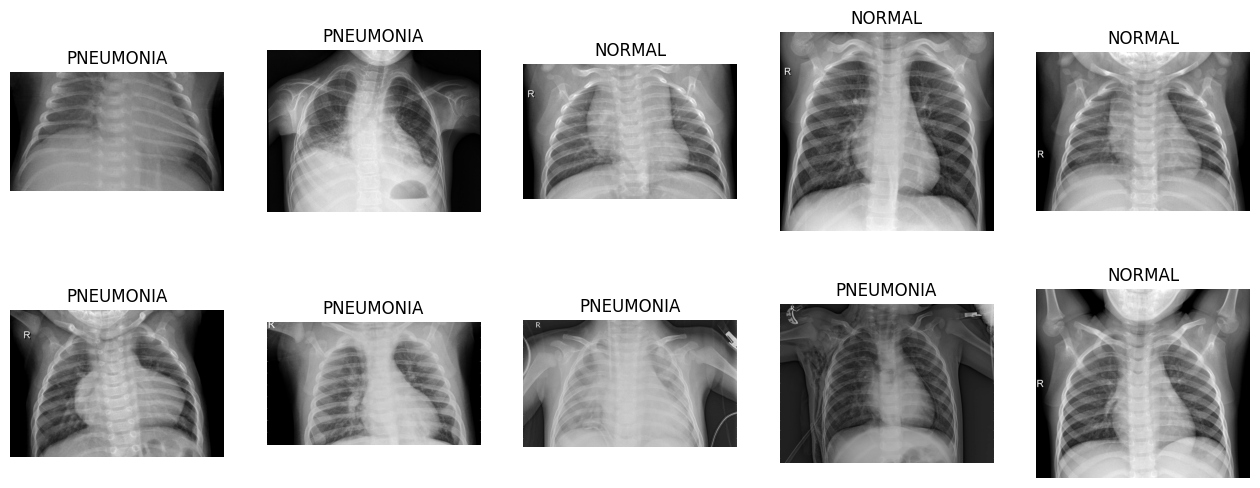

In [152]:
import matplotlib.image as mpimg

# Show some images along with their labels
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    idx = np.random.randint(0, len(image_datasets['train'].samples))
    image_path, label_idx = image_datasets['train'].samples[idx]  # Get image path and label index
    image = mpimg.imread(image_path)  # Read image
    label = list(image_datasets['train'].class_to_idx.keys())[label_idx]  # Get label
    plt.imshow(image,cmap='gray')
    plt.title(label)  # Display label as title
    plt.axis('off')

plt.show()

In [153]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    acc_history = {"train": [], "val": []}
    losses = {"train": [], "val": []}

    # we will keep a copy of the best weights so far according to validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            print('{} Phase'.format(phase))
            print('-' * 10)
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                print('Batch {}/{}'.format(batch_idx, len(dataloaders[phase])))
                print('-' * 10)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    losses[phase].append(loss)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            acc_history[phase].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_history, losses



In [154]:
def initialize_model(num_classes):
    # Resnet18 
    model = models.resnet18()
    
    model.fc = nn.Linear(512,2) # YOUR CODE HERE!
    
    input_size = 224
        
    return model, input_size


# Number of classes in the dataset
num_classes = 2

# Initialize the model
model, input_size = initialize_model(num_classes)

# Print the model we just instantiated
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [155]:

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Number of epochs to train for 
num_epochs = 15

optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
# Train and evaluate
model, hist, losses = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------
train Phase
----------
Batch 0/37
----------
Batch 1/37
----------
Batch 2/37
----------
Batch 3/37
----------
Batch 4/37
----------
Batch 5/37
----------
Batch 6/37
----------
Batch 7/37
----------
Batch 8/37
----------
Batch 9/37
----------
Batch 10/37
----------
Batch 11/37
----------
Batch 12/37
----------
Batch 13/37
----------
Batch 14/37
----------
Batch 15/37
----------
Batch 16/37
----------
Batch 17/37
----------
Batch 18/37
----------
Batch 19/37
----------
Batch 20/37
----------
Batch 21/37
----------
Batch 22/37
----------
Batch 23/37
----------
Batch 24/37
----------
Batch 25/37
----------
Batch 26/37
----------
Batch 27/37
----------
Batch 28/37
----------
Batch 29/37
----------
Batch 30/37
----------
Batch 31/37
----------
Batch 32/37
----------
Batch 33/37
----------
Batch 34/37
----------
Batch 35/37
----------
Batch 36/37
----------
train Loss: 0.3551 Acc: 0.8668
val Phase
----------
Batch 0/5
----------
Batch 1/5
----------
Batch 2/5
----------

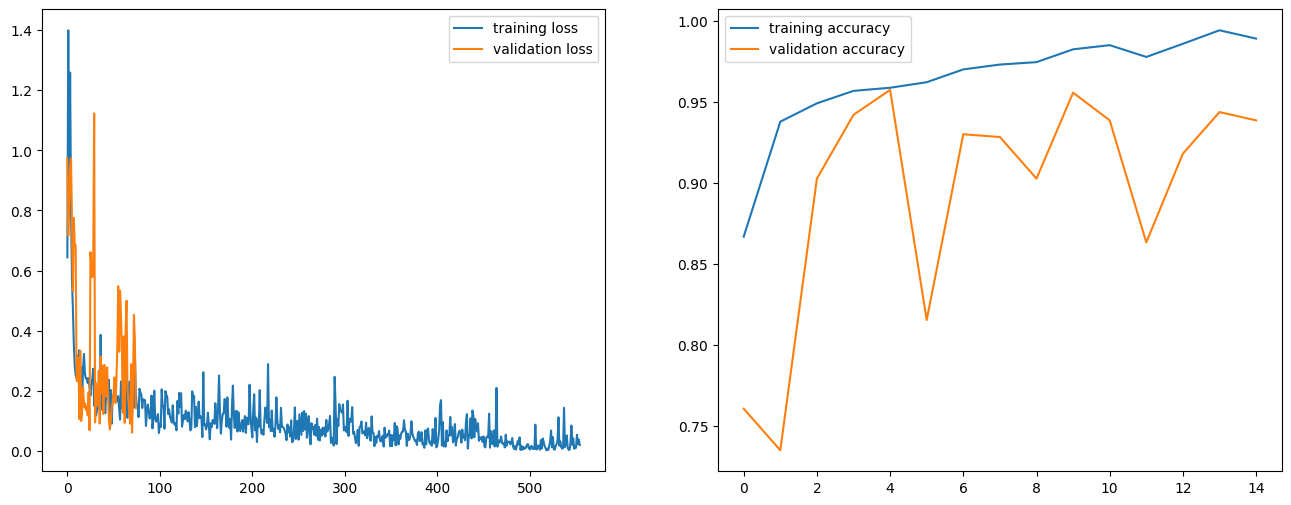

In [156]:
# plot the losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Detach tensors before converting to numpy arrays
train_losses = [loss.detach().numpy() for loss in losses["train"]]
val_losses = [loss.detach().numpy() for loss in losses["val"]]
train_accs = [acc.detach().numpy() for acc in hist["train"]]
val_accs = [acc.detach().numpy() for acc in hist["val"]]

ax1.plot(train_losses, label="training loss")
ax1.plot(val_losses, label="validation loss")
ax1.legend()

ax2.plot(train_accs, label="training accuracy")
ax2.plot(val_accs, label="validation accuracy")
ax2.legend()

plt.show()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [81]:
def predict_image(image, model, data_transforms):
    # Apply transformations to the input image
    input_tensor = data_transforms(image)
    # Add batch dimension
    input_tensor = input_tensor.unsqueeze(0)
    # Move input tensor to the appropriate device (GPU if available, otherwise CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_tensor = input_tensor.to(device)
    # Set model to evaluation mode
    model.eval()
    # Make predictions
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        # Map the predicted class index to the class label
        class_label = "NORMAL" if predicted.item() == 0 else "PNEUMONIA"
    return class_label


In [157]:
data_dir = "../data/external/chest_xray_new/"

# ResNet input size
input_size = (254,254)

# Just normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        #ToGrayTensor(),
        transforms.Normalize(0.485, 0.229)  # Use single mean and standard deviation
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        #ToGrayTensor(),
        transforms.Normalize(0.485, 0.229)  # Use single mean and standard deviation
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        #ToGrayTensor(),
        transforms.Normalize(0.485, 0.229)  # Use single mean and standard deviation
    ]),
}

In [158]:
image_datasets_test = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['test']}
# Create training and validation dataloaders
#dataloaders_dict_test = {x: torch.utils.data.DataLoader(image_datasets[x], shuffle=False) for x in ['test']}

In [160]:
num_samples_test = len(image_datasets_test['test'])
print("Number of samples in training set:", num_samples_test)

Number of samples in training set: 587


In [182]:
# Create an empty list to store the predicted labels
predicted_labels_test = []

# Iterate over the test dataset
for inputs, _ in image_datasets_test['test']:

    inputs = inputs.unsqueeze(0)

    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
    
    # Map the predicted class index to the class label
    #class_label = "NORMAL" if predicted.item() == 0 else "PNEUMONIA"
    
    # Append the predicted label to the list
    predicted_labels_test.append(predicted.item())

# Print the predicted labels
print(predicted_labels_test)

[1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [183]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# True labels for the test set
true_labels = [class_label for _, class_label in image_datasets_test['test']]

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels_test)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(true_labels, predicted_labels_test)
print("Classification Report:")
print(class_report)

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels_test)
print("Accuracy:", accuracy)

# F1-score
f1 = f1_score(true_labels, predicted_labels_test, average='weighted')
print("F1-score:", f1)

Confusion Matrix:
[[135  24]
 [ 10 418]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       159
           1       0.95      0.98      0.96       428

    accuracy                           0.94       587
   macro avg       0.94      0.91      0.92       587
weighted avg       0.94      0.94      0.94       587

Accuracy: 0.9420783645655877
F1-score: 0.9412106788442056


In [193]:
FP = np.array([index for (index, pred), target in zip(enumerate(predicted_labels_test),true_labels) if (pred==1 and target==0)])
FN = np.array([index for (index, pred), target in zip(enumerate(predicted_labels_test),true_labels) if (pred==0 and target==1)])

In [190]:
print(len(predicted_labels_test))

587


In [194]:
print(len(FP))
print(len(FN))

24
10


In [230]:
def plot_images(dataset, indexes, title):
    plt.figure(figsize=(12, 16))
    plt.suptitle(title)
    num_images = len(indexes)
    rows = int(np.ceil(num_images / 4))
    for i, idx in enumerate(indexes):
        plt.subplot(rows, 4, i + 1)
        plt.imshow(dataset[idx][0].numpy()[0],cmap='gray')  # Assuming dataset is a list/array of images
        plt.title(f'Index: {idx}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

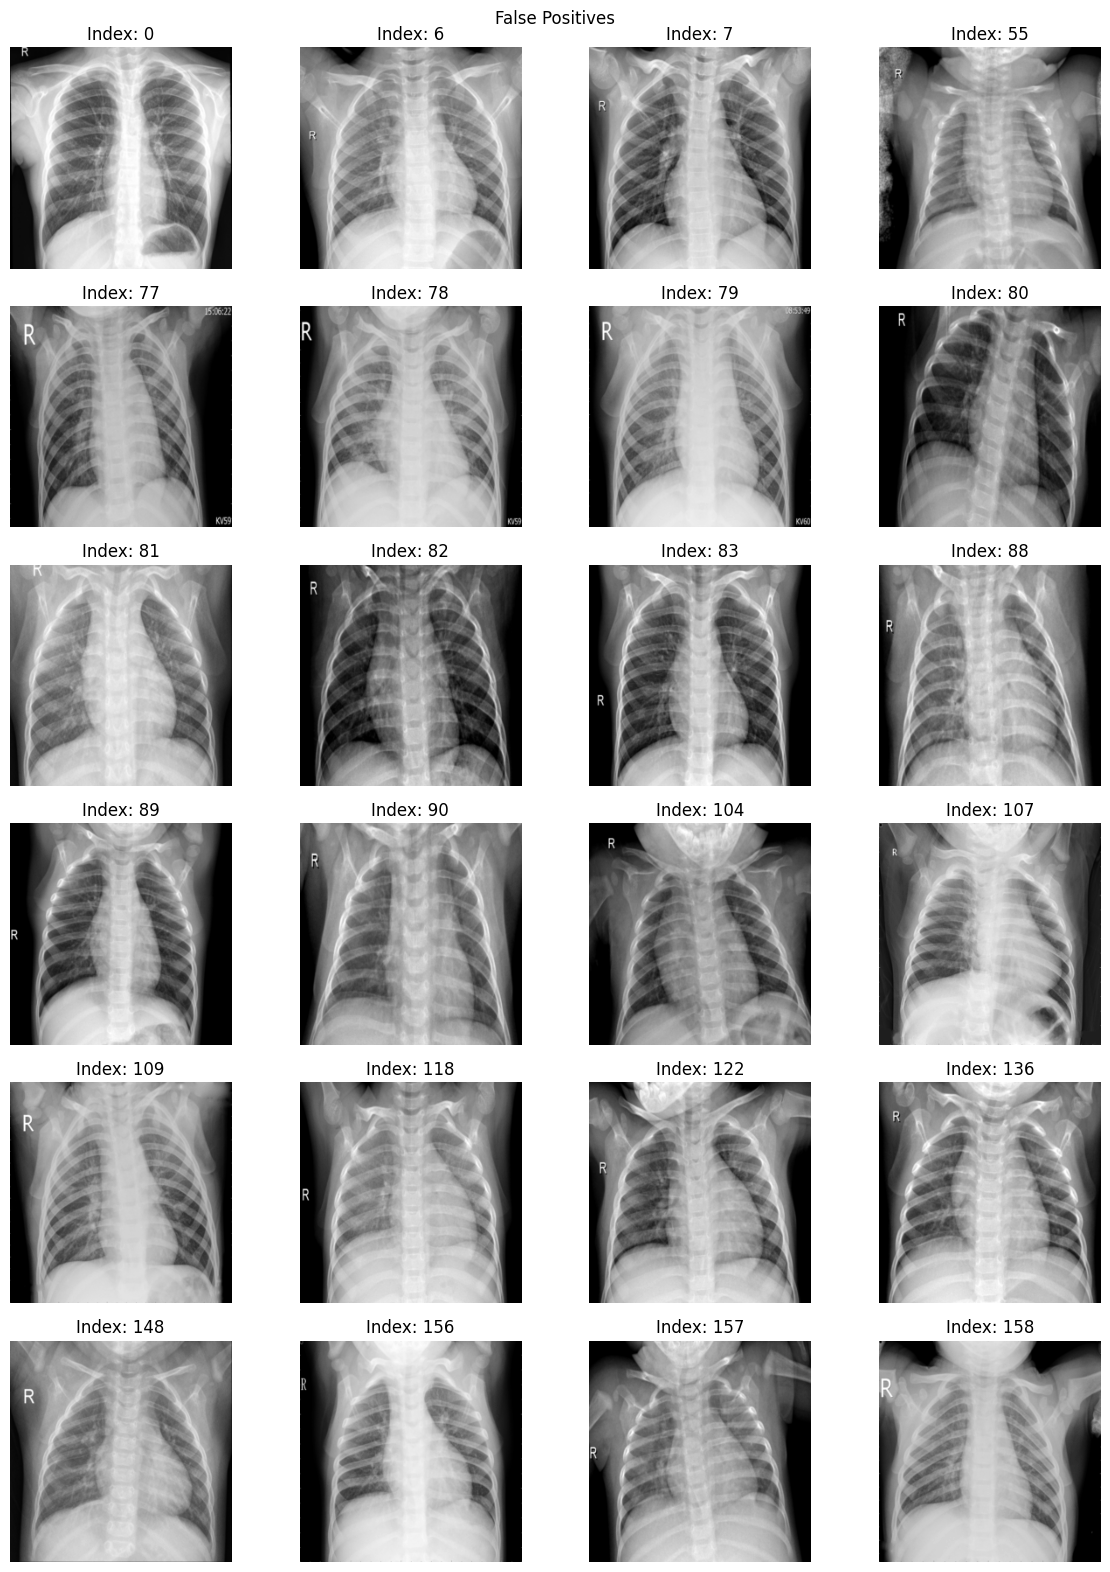

In [231]:
plot_images(image_datasets_test['test'], FP, "False Positives")

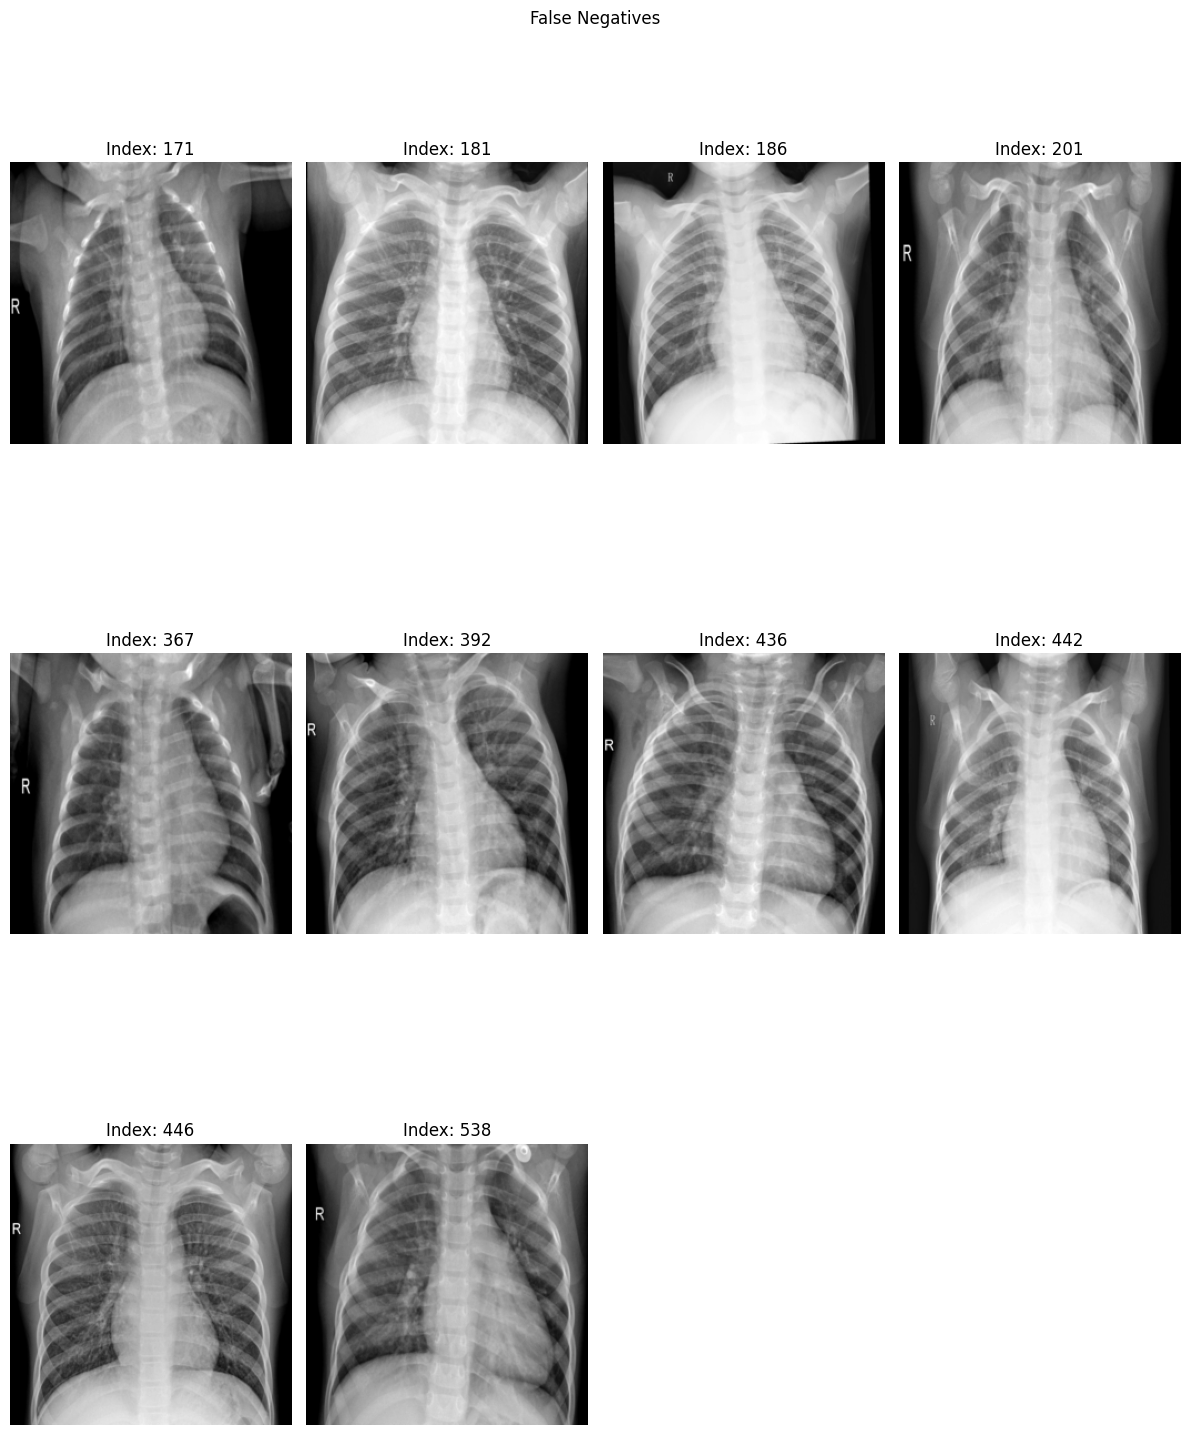

In [232]:
plot_images(image_datasets_test['test'], FN, "False Negatives")

In [176]:
images_pred = (Image.open('../data/interim/propio/Rx_before.jpeg'),Image.open('../data/interim/propio/Rx_after.jpeg'))

In [165]:
transformer = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.Grayscale(num_output_channels=3), 
        transforms.ToTensor(),
        #ToGrayTensor(),
        transforms.Normalize(0.485, 0.229)  # Use single mean and standard deviation
    ])

In [166]:
datasetfor_pred = []
for img in images_pred:
    datasetfor_pred.append(transformer(img))

In [167]:
print(datasetfor_pred)

[tensor([[[-2.1008, -2.0837, -2.0837,  ..., -2.1008, -2.1008, -2.1008],
         [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
         [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
         ...,
         [-2.1179, -2.1179, -2.1179,  ...,  1.3927,  1.0502, -0.4739],
         [-2.1179, -2.1179, -2.1179,  ..., -0.5253, -0.5767, -1.3644],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.1008, -2.0837, -2.0837,  ..., -2.1008, -2.1008, -2.1008],
         [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
         [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
         ...,
         [-2.1179, -2.1179, -2.1179,  ...,  1.3927,  1.0502, -0.4739],
         [-2.1179, -2.1179, -2.1179,  ..., -0.5253, -0.5767, -1.3644],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.1008, -2.0837, -2.0837,  ..., -2.1008, -2.1008, -2.1008],
         [-2.1008, -2.1008, -2.1008,  ..., -

torch.Size([254, 254])
torch.Size([254, 254])


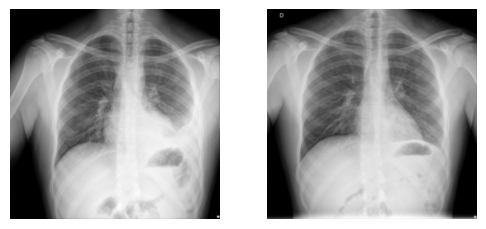

In [168]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(2):
    plt.subplot(2, 5, i + 1)
    plt.imshow(datasetfor_pred[i][0],cmap='gray')
    print(datasetfor_pred[i][0].shape)
    plt.axis('off');

In [169]:
predicted_labels_test_2 = []

# Iterate over the test dataset
for inputs in datasetfor_pred:

    inputs = inputs.unsqueeze(0)

    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
    
    # Map the predicted class index to the class label
    #class_label = "NORMAL" if predicted.item() == 0 else "PNEUMONIA"
    
    # Append the predicted label to the list
    predicted_labels_test_2.append(predicted.item())

# Print the predicted labels
print(predicted_labels_test_2)

[1, 0]
